In [1]:
%matplotlib inline

11493376/11490434 [==============================] - 0s 0us/step


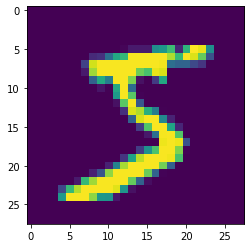

In [2]:
import numpy as np
import cv2
np.random.seed(123) 
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Convolution2D, MaxPooling2D 

from keras.utils import np_utils

from keras.datasets import mnist 
 

(X_train, y_train), (X_test, y_test) = mnist.load_data() 
plt.imshow(X_train[0])
plt.show()

X_train = X_train.reshape(X_train.shape[0],28, 28, 1) 
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [3]:
data_set_patch =[]
data_set_flatten =[]

data_test_flatten =[]

for train_img  in X_train :
    patch_train_seq =[]
    flatten_train_seq =[]
    
    for i in range(4) :
        for j in range(4):
            patch_train = train_img[i*7:(i+1)*7 , j*7 : (j+1)*7 , 0 ]
            flatten_train_patch = np.array(patch_train).flatten()
            
            
            flatten_train_seq.append(flatten_train_patch)
            patch_train_seq.append(patch_train)
            
    patch_train_seq = np.array(patch_train_seq)
    flatten_train_seq = np.array(flatten_train_seq)
    
    data_set_patch.append(patch_train_seq)
    data_set_flatten.append(flatten_train_seq)
    
    
for test_img  in X_test :
    
    flatten_test_seq =[]
    
    for i in range(4) :
        for j in range(4):
            patch_test = test_img[i*7:(i+1)*7 , j*7 : (j+1)*7 , 0 ]
            flatten_test_patch = np.array(patch_test).flatten()
            
            
            flatten_test_seq.append(flatten_test_patch)
        
    flatten_test_seq = np.array(flatten_test_seq)
    
    data_test_flatten.append(flatten_test_seq)

# Prepare the input and target datasets

In [4]:
train_data_set =[]
target_data_set =[]

test_data_set =[]
test_target_set =[]

for train_flatten  in data_set_flatten  :
    train_data_set.append( train_flatten[:-1]  )
    target_data_set.append( train_flatten[1:] )
    
for test_flatten in data_test_flatten :
    test_data_set.append( test_flatten[:-1]  )
    test_target_set.append( test_flatten[1:] )

In [5]:
train_data_set = np.array(train_data_set)
target_data_set = np.array(target_data_set)

test_data_set = np.array(test_data_set)
test_target_set = np.array(test_target_set)

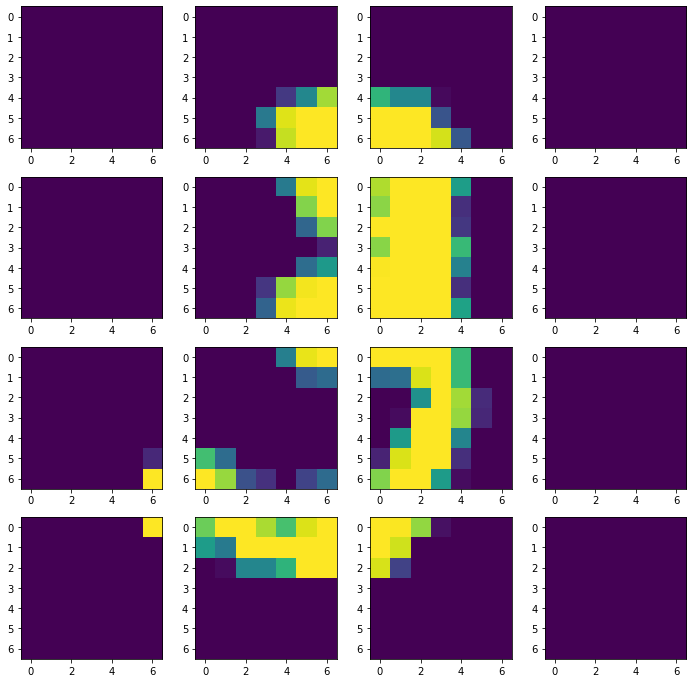

In [6]:
#simple visualization
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
random_sample = data_set_patch[10]
for ax , i_sample in zip(axs , random_sample):
        ax.imshow(i_sample)
plt.show()

In [7]:
from torch.utils.data import Dataset

class SeqData(Dataset):
    def __init__(self , x_set , y_set ) :
        super(SeqData , self).__init__()
        self.x = x_set
        self.y = y_set
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self , index):
        
        return self.x[index] , self.y[index]

In [8]:
from torch.utils.data import DataLoader , TensorDataset

train_dataset = SeqData( train_data_set , target_data_set ) # create your datset
test_dataset = SeqData( test_data_set , test_target_set ) # create your datset

train_dataloader = DataLoader(train_dataset , batch_size=100 , shuffle=True , drop_last=True) # create your dataloader
test_dataloader = DataLoader(test_dataset , batch_size=100 , shuffle=True , drop_last=True) # create your dataloader

In [9]:
x , y = next(iter(train_dataloader))

In [10]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lstm_size = 64
        self.num_layers = 2

        self.lstm = nn.LSTM(input_size=49,hidden_size=self.lstm_size,
            num_layers=self.num_layers,dropout=0.2,batch_first =True)
        
        self.fc = nn.Linear(self.lstm_size,49 )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, prev_state):

        output, state = self.lstm(x , prev_state)
        fc_in  = output.contiguous().view(-1,self.lstm_size)
        
        logits = self.fc(fc_in)
        logits = self.sigmoid(logits)
        logits = logits.view(x.shape[0] , x.shape[1] , x.shape[2])
        
        return logits, state

    def init_state(self, batch_size):
        return (torch.zeros(  self.num_layers,batch_size ,   self.lstm_size),
                torch.zeros(  self.num_layers,batch_size ,  self.lstm_size))

In [11]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from collections import deque

model= Model()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(300):
    state_h, state_c = model.init_state(100)
    epoch_loss = deque(maxlen=500)
    for batch, (x, y) in enumerate(train_dataloader):
        
        optimizer.zero_grad()

        y_pred, (state_h, state_c) = model(x, (state_h, state_c))
        loss = criterion(y_pred, y)
        
        epoch_loss.append(loss.detach().to("cpu").numpy())
        state_h = state_h.detach()
        state_c = state_c.detach()

        loss.backward()
        optimizer.step()

    print('epoch  {} Train loss {:.6f} '.format(epoch , np.mean(epoch_loss) ))
        
    model.eval()
    
    with torch.no_grad():  
        epoch_val_loss = deque(maxlen=300)
        state_h, state_c = model.init_state(100)
        for batch, (x, y) in enumerate(test_dataloader):

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred, y)

            epoch_val_loss.append(loss.detach().to("cpu").numpy())
            state_h = state_h.detach()
            state_c = state_c.detach()


    print('epoch  {} Test loss {:.6f} '.format(epoch , np.mean(epoch_val_loss) ))
        
    model.train()

epoch  0 Train loss 0.083420 
epoch  0 Test loss 0.070440 
epoch  1 Train loss 0.061710 
epoch  1 Test loss 0.055253 
epoch  2 Train loss 0.052492 
epoch  2 Test loss 0.048083 
epoch  3 Train loss 0.047404 
epoch  3 Test loss 0.043791 
epoch  4 Train loss 0.044204 
epoch  4 Test loss 0.040940 
epoch  5 Train loss 0.042040 
epoch  5 Test loss 0.039038 
epoch  6 Train loss 0.040492 
epoch  6 Test loss 0.037550 
epoch  7 Train loss 0.039125 
epoch  7 Test loss 0.036383 
epoch  8 Train loss 0.038023 
epoch  8 Test loss 0.035420 
epoch  9 Train loss 0.037142 
epoch  9 Test loss 0.034683 
epoch  10 Train loss 0.036482 
epoch  10 Test loss 0.034041 
epoch  11 Train loss 0.035903 
epoch  11 Test loss 0.033696 
epoch  12 Train loss 0.035462 
epoch  12 Test loss 0.033236 
epoch  13 Train loss 0.035046 
epoch  13 Test loss 0.032794 
epoch  14 Train loss 0.034614 
epoch  14 Test loss 0.032435 
epoch  15 Train loss 0.034346 
epoch  15 Test loss 0.032274 
epoch  16 Train loss 0.034038 
epoch  16 Tes

epoch  134 Train loss 0.028969 
epoch  134 Test loss 0.028142 
epoch  135 Train loss 0.028942 
epoch  135 Test loss 0.028066 
epoch  136 Train loss 0.028958 
epoch  136 Test loss 0.028138 
epoch  137 Train loss 0.028959 
epoch  137 Test loss 0.028107 
epoch  138 Train loss 0.028917 
epoch  138 Test loss 0.028036 
epoch  139 Train loss 0.028957 
epoch  139 Test loss 0.028064 
epoch  140 Train loss 0.028937 
epoch  140 Test loss 0.028004 
epoch  141 Train loss 0.028925 
epoch  141 Test loss 0.028027 
epoch  142 Train loss 0.028898 
epoch  142 Test loss 0.028149 
epoch  143 Train loss 0.028940 
epoch  143 Test loss 0.028047 
epoch  144 Train loss 0.028887 
epoch  144 Test loss 0.028142 
epoch  145 Train loss 0.028855 
epoch  145 Test loss 0.028022 
epoch  146 Train loss 0.028874 
epoch  146 Test loss 0.028010 
epoch  147 Train loss 0.028879 
epoch  147 Test loss 0.028020 
epoch  148 Train loss 0.028826 
epoch  148 Test loss 0.027998 
epoch  149 Train loss 0.028841 
epoch  149 Test loss 0.

epoch  264 Test loss 0.027726 
epoch  265 Train loss 0.028305 
epoch  265 Test loss 0.027696 
epoch  266 Train loss 0.028307 
epoch  266 Test loss 0.027749 
epoch  267 Train loss 0.028285 
epoch  267 Test loss 0.027694 
epoch  268 Train loss 0.028288 
epoch  268 Test loss 0.027692 
epoch  269 Train loss 0.028296 
epoch  269 Test loss 0.027753 
epoch  270 Train loss 0.028320 
epoch  270 Test loss 0.027704 
epoch  271 Train loss 0.028291 
epoch  271 Test loss 0.027731 
epoch  272 Train loss 0.028307 
epoch  272 Test loss 0.027735 
epoch  273 Train loss 0.028251 
epoch  273 Test loss 0.027668 
epoch  274 Train loss 0.028239 
epoch  274 Test loss 0.027718 
epoch  275 Train loss 0.028292 
epoch  275 Test loss 0.027709 
epoch  276 Train loss 0.028250 
epoch  276 Test loss 0.027724 
epoch  277 Train loss 0.028232 
epoch  277 Test loss 0.027652 
epoch  278 Train loss 0.028289 
epoch  278 Test loss 0.027900 
epoch  279 Train loss 0.028237 
epoch  279 Test loss 0.027674 
epoch  280 Train loss 0.

In [12]:
def predict(sample):
    model.eval()
    tensor = torch.from_numpy(sample).unsqueeze(0)
    hidden_state = model.init_state(1)
    
    prediction , hidden_state = model.forward(tensor , hidden_state )
    
    sample_in = prediction[:,-1,:]
    
    predict_patches =[ i_sample  for i_sample in sample]
    predict_patches.append(sample_in.squeeze(0).detach().numpy())
    sample_in = sample_in.unsqueeze(1)
    for i in range(7):        
        
        sample_out  , hidden_state = model( sample_in, hidden_state )
        predict_patches.append(sample_out.squeeze(0).squeeze(1).detach().numpy())
        sample_in = sample_out

    return predict_patches

In [13]:
class_dict ={"0":[] , "1":[] , "2":[], "3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[]}

for i_patch , i_target in zip(data_test_flatten , y_test):
    if(len(class_dict[str(i_target)]) < 10 ):
        class_dict[str(i_target)].extend([i_patch])

In [14]:
pred_dict ={"0":[] , "1":[] , "2":[], "3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[]}
target_dict ={"0":[] , "1":[] , "2":[], "3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[]}
for i_item in class_dict.items():
    for i in i_item[1] :
        prediction = predict(i[:8])
        pred_img = np.zeros((28,28))
        original_img= np.zeros((28,28))
        count = -1
        for j in range(4):
            for k in range(4):
                count +=1
                i_sample = prediction[count].reshape(7,7)
                pred_img[ j*7:(j+1)*7 , k*7 : (k+1)*7  ] = i_sample     
                
        count =-1        
        for j in range(4):
            for k in range(4):
                count +=1
                i_sample = i[count].reshape(7,7)
                original_img[ j*7:(j+1)*7 , k*7 : (k+1)*7  ] = i_sample   

        pred_dict[i_item[0]].extend([pred_img.copy()])
        target_dict[i_item[0]].extend([original_img.copy()])

Predicted Images 


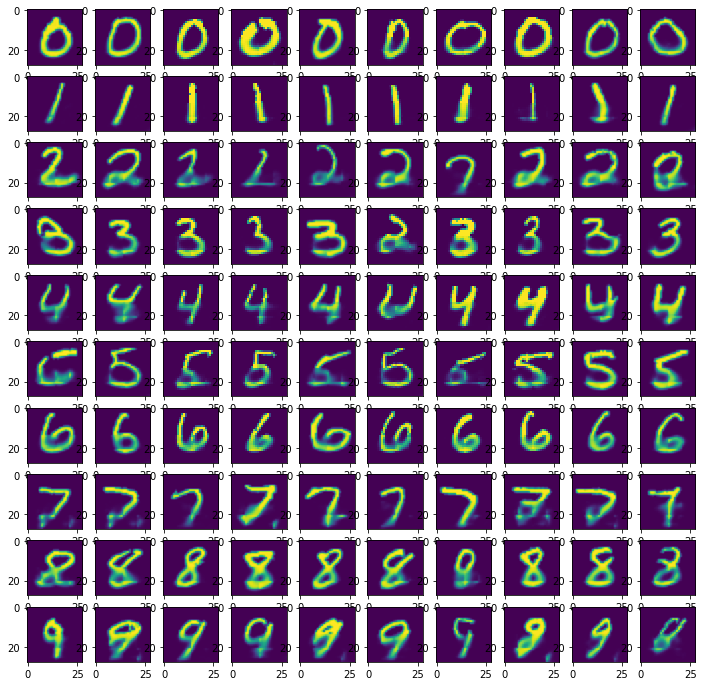

In [15]:
print("Predicted Images ")
#simple visualization
_, axs = plt.subplots(10, 10, figsize=(12 , 12))
for ax , i_sample in zip(axs ,pred_dict.items() ):
        for i in range(10):
            ax[i].imshow(i_sample[1][i])
            

plt.show()

Ground Truth Images


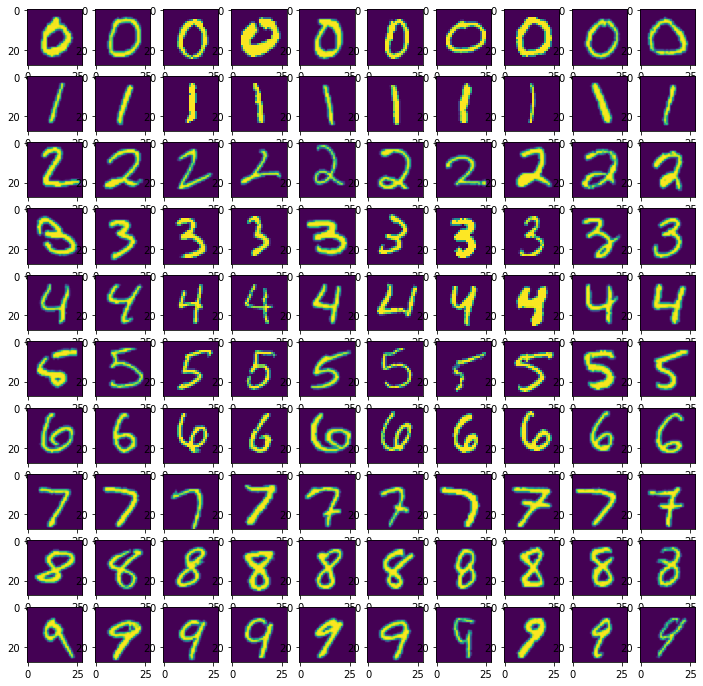

In [16]:
#simple visualization
print("Ground Truth Images")
_, axs = plt.subplots(10, 10, figsize=(12 , 12))
for ax , i_sample in zip(axs ,target_dict.items() ):
        for i in range(10):
            ax[i].imshow(i_sample[1][i])
            

plt.show()